In [1]:
library(foreign)
library(ggplot2)
library(MASS)
library(Hmisc)
library(reshape2)

Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, units



### Examples of ordered logistic regression

### Description of the Data

In [2]:
dat <- read.dta("./datasets/ologit.dta")
head(dat)

apply,pared,public,gpa
very likely,0,0,3.26
somewhat likely,1,0,3.21
unlikely,1,1,3.94
somewhat likely,0,0,2.81
somewhat likely,0,0,2.53
unlikely,0,1,2.59


In [3]:
## one at a time, table apply, pared, and public
lapply(dat[, c("apply", "pared", "public")], table)

$apply

       unlikely somewhat likely     very likely 
            220             140              40 

$pared

  0   1 
337  63 

$public

  0   1 
343  57 


In [4]:
## three way cross tabs (xtabs) and flatten the table
ftable(xtabs(~ public + apply + pared, data = dat))

                       pared   0   1
public apply                        
0      unlikely              175  14
       somewhat likely        98  26
       very likely            20  10
1      unlikely               25   6
       somewhat likely        12   4
       very likely             7   3

In [5]:
summary(dat$gpa)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.900   2.720   2.990   2.999   3.270   4.000 

In [6]:
sd(dat$gpa)

[1] 0.3979409

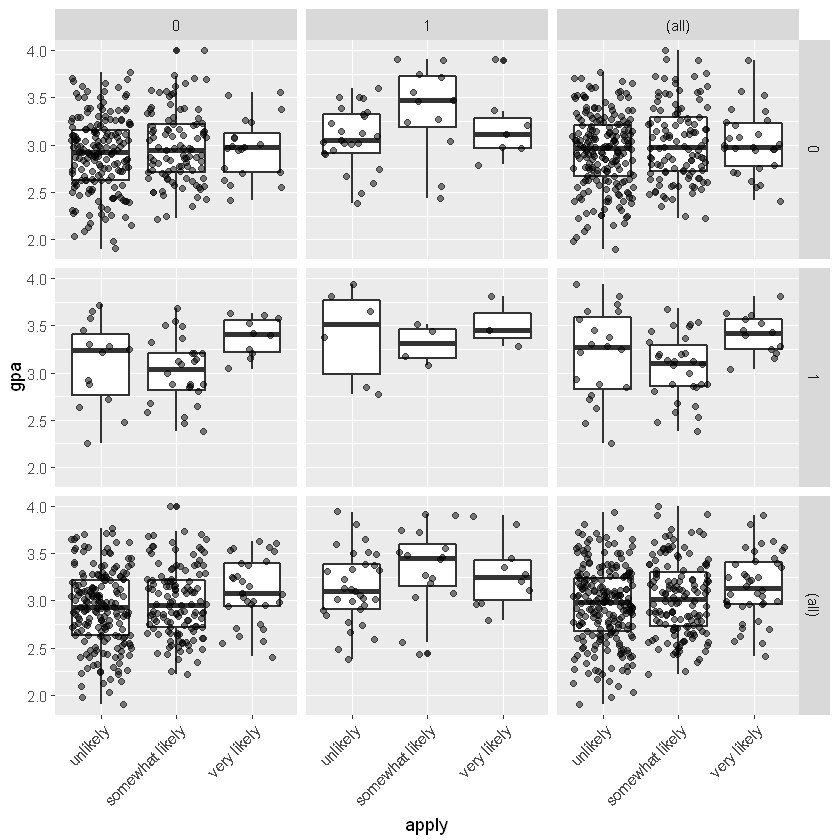

In [7]:
ggplot(dat, aes(x = apply, y = gpa)) +
    geom_boxplot(size = .75) + geom_jitter(alpha = .5) + facet_grid(pared ~ public, margins = TRUE) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))

### Analysis methods you might consider

### Ordered logistic regression

In [8]:
## fit ordered logit model and store results 'm'
m <- polr(apply ~ pared + public + gpa, data = dat, Hess=TRUE)

## view a summary of the model
summary(m)

Call:
polr(formula = apply ~ pared + public + gpa, data = dat, Hess = TRUE)

Coefficients:
          Value Std. Error t value
pared   1.04769     0.2658  3.9418
public -0.05879     0.2979 -0.1974
gpa     0.61594     0.2606  2.3632

Intercepts:
                            Value   Std. Error t value
unlikely|somewhat likely     2.2039  0.7795     2.8272
somewhat likely|very likely  4.2994  0.8043     5.3453

Residual Deviance: 717.0249 
AIC: 727.0249 

In [9]:
## store table
(ctable <- coef(summary(m)))

,Value,Std. Error,t value
pared,1.04769010,0.2657894,3.9418050
public,-0.05878572,0.2978614,-0.1973593
gpa,0.61594057,0.2606340,2.3632399
unlikely|somewhat likely,2.20391473,0.7795455,2.8271792
somewhat likely|very likely,4.29936315,0.8043267,5.3452947


In [10]:
## calculate and store p values
p <- pnorm(abs(ctable[, "t value"]), lower.tail = FALSE) * 2

In [11]:
## combined table
(ctable <- cbind(ctable, "p value" = p))

,Value,Std. Error,t value,p value
pared,1.04769010,0.2657894,3.9418050,8.087072e-05
public,-0.05878572,0.2978614,-0.1973593,8.435464e-01
gpa,0.61594057,0.2606340,2.3632399,1.811594e-02
unlikely|somewhat likely,2.20391473,0.7795455,2.8271792,4.696004e-03
somewhat likely|very likely,4.29936315,0.8043267,5.3452947,9.027008e-08


In [12]:
(ci <- confint(m)) # default method gives profiled CIs

Waiting for profiling to be done...


,2.5 %,97.5 %
pared,0.5281768,1.5721750
public,-0.6522060,0.5191384
gpa,0.1076202,1.1309148


In [13]:
confint.default(m) # CIs assuming normality

,2.5 %,97.5 %
pared,0.5267524,1.5686278
public,-0.6425833,0.5250119
gpa,0.1051074,1.1267737


In [14]:
## odds ratios
exp(coef(m))

pared    public       gpa 
2.8510579 0.9429088 1.8513972

In [15]:
## OR and CI
exp(cbind(OR = coef(m), ci))

,OR,2.5 %,97.5 %
pared,2.8510579,1.6958376,4.817114
public,0.9429088,0.5208954,1.680579
gpa,1.8513972,1.1136247,3.098490


In [16]:
sf <- function(y) {
      c('Y>=1' = qlogis(mean(y >= 1)),
        'Y>=2' = qlogis(mean(y >= 2)),
        'Y>=3' = qlogis(mean(y >= 3)))   }

(s <- with(dat, summary(as.numeric(apply) ~ pared + public + gpa, fun=sf)))

as.numeric(apply)     N= 400 

+-------+-----------+---+----+-----------+---------+
|       |           |N  |Y>=1|Y>=2       |Y>=3     |
+-------+-----------+---+----+-----------+---------+
|pared  |No         |337|Inf |-0.37833644|-2.440735|
|       |Yes        | 63|Inf | 0.76546784|-1.347074|
+-------+-----------+---+----+-----------+---------+
|public |No         |343|Inf |-0.20479441|-2.345006|
|       |Yes        | 57|Inf |-0.17589067|-1.547563|
+-------+-----------+---+----+-----------+---------+
|gpa    |[1.90,2.73)|102|Inf |-0.39730180|-2.772589|
|       |[2.73,3.00)| 99|Inf |-0.26415158|-2.302585|
|       |[3.00,3.28)|100|Inf |-0.20067070|-2.090741|
|       |[3.28,4.00]| 99|Inf | 0.06062462|-1.803594|
+-------+-----------+---+----+-----------+---------+
|Overall|           |400|Inf |-0.20067070|-2.197225|
+-------+-----------+---+----+-----------+---------+

In [17]:
glm(I(as.numeric(apply) >= 2) ~ pared, family="binomial", data = dat)


Call:  glm(formula = I(as.numeric(apply) >= 2) ~ pared, family = "binomial", 
    data = dat)

Coefficients:
(Intercept)        pared  
    -0.3783       1.1438  

Degrees of Freedom: 399 Total (i.e. Null);  398 Residual
Null Deviance:	    550.5 
Residual Deviance: 534.1 	AIC: 538.1

In [18]:
glm(I(as.numeric(apply) >= 3) ~ pared, family="binomial", data = dat)


Call:  glm(formula = I(as.numeric(apply) >= 3) ~ pared, family = "binomial", 
    data = dat)

Coefficients:
(Intercept)        pared  
     -2.441        1.094  

Degrees of Freedom: 399 Total (i.e. Null);  398 Residual
Null Deviance:	    260.1 
Residual Deviance: 252.2 	AIC: 256.2

In [19]:
s[, 4] <- s[, 4] - s[, 3]
s[, 3] <- s[, 3] - s[, 3]

# print
s

as.numeric(apply)     N= 400 

+-------+-----------+---+----+----+---------+
|       |           |N  |Y>=1|Y>=2|Y>=3     |
+-------+-----------+---+----+----+---------+
|pared  |No         |337|Inf |0   |-2.062399|
|       |Yes        | 63|Inf |0   |-2.112541|
+-------+-----------+---+----+----+---------+
|public |No         |343|Inf |0   |-2.140211|
|       |Yes        | 57|Inf |0   |-1.371672|
+-------+-----------+---+----+----+---------+
|gpa    |[1.90,2.73)|102|Inf |0   |-2.375287|
|       |[2.73,3.00)| 99|Inf |0   |-2.038434|
|       |[3.00,3.28)|100|Inf |0   |-1.890070|
|       |[3.28,4.00]| 99|Inf |0   |-1.864219|
+-------+-----------+---+----+----+---------+
|Overall|           |400|Inf |0   |-1.996554|
+-------+-----------+---+----+----+---------+

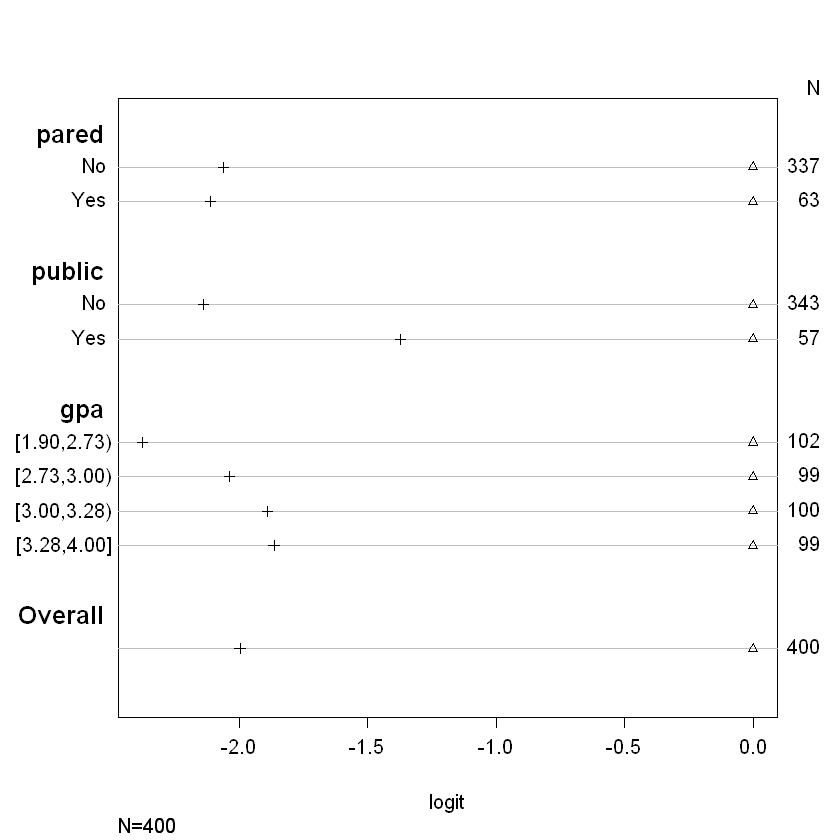

In [20]:
plot(s, which=1:3, pch=1:3, xlab='logit', main=' ', xlim=range(s[,3:4]))

In [21]:
newdat <- data.frame(
          pared = rep(0:1, 200),
          public = rep(0:1, each = 200),
          gpa = rep(seq(from = 1.9, to = 4, length.out = 100), 4))
newdat <- cbind(newdat, predict(m, newdat, type = "probs"))

##show first few rows
head(newdat)

pared,public,gpa,unlikely,somewhat likely,very likely
0,0,1.900000,0.7376186,0.2204577,0.04192370
1,0,1.921212,0.4932185,0.3945673,0.11221424
0,0,1.942424,0.7325300,0.2244841,0.04298593
1,0,1.963636,0.4866885,0.3984676,0.11484395
0,0,1.984848,0.7273792,0.2285470,0.04407383
1,0,2.006061,0.4801630,0.4023098,0.11752712


In [22]:
lnewdat <- melt(newdat, id.vars = c("pared", "public", "gpa"), variable.name = "Level", value.name="Probability")

## view first few rows
head(lnewdat)

pared,public,gpa,Level,Probability
0,0,1.900000,unlikely,0.7376186
1,0,1.921212,unlikely,0.4932185
0,0,1.942424,unlikely,0.7325300
1,0,1.963636,unlikely,0.4866885
0,0,1.984848,unlikely,0.7273792
1,0,2.006061,unlikely,0.4801630


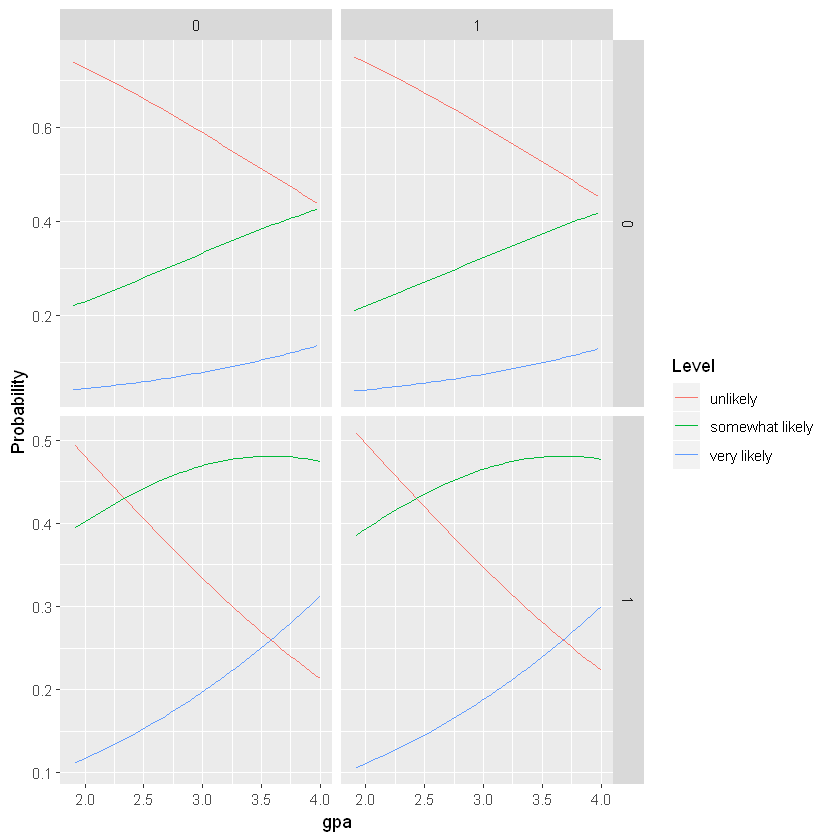

In [23]:
ggplot(lnewdat, aes(x = gpa, y = Probability, colour = Level)) +
    geom_line() + facet_grid(pared ~ public, scales="free")

### Things to consider